## Load and visualize FashionMNIST 

The first step in any classification problem is to look at the dataset you are working with. This will give you some details about the format of images and labels, as well as some insight into how you might approach defining a network to recognize patterns in such an image set.

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import numpy as np
import torch
import torchvision

# data loading and transforming 
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader 
from torchvision import transforms 

# network architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

## Load training data 

In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

data_transform = transforms.ToTensor()
train_data = FashionMNIST(root='./datasets', train=True, download=False, transform=data_transform)
test_data = FashionMNIST(root='./datasets', train=False, download=False, transform=data_transform)

print("Train data, number of images: ", len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


## Data iteration and batching

In [114]:
batch_size = 40
# DataLoader is an iterator
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Specify the image classes
classes =['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualize some training data

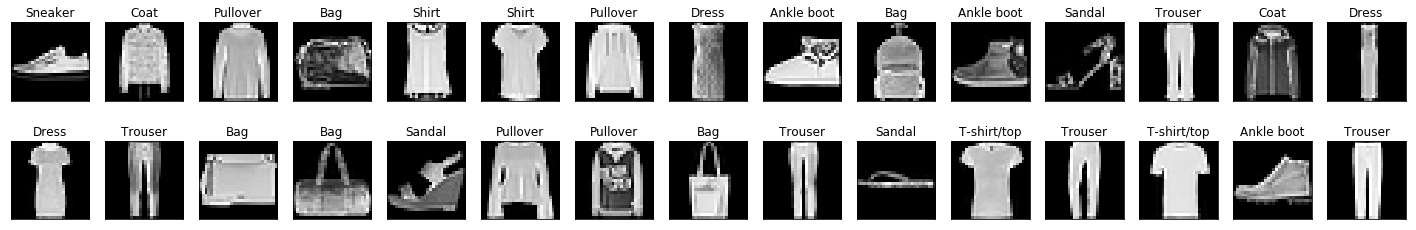

In [105]:
# Obtain one batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap ='gray')
    ax.set_title(classes[labels[idx]])

## View an image in more detail

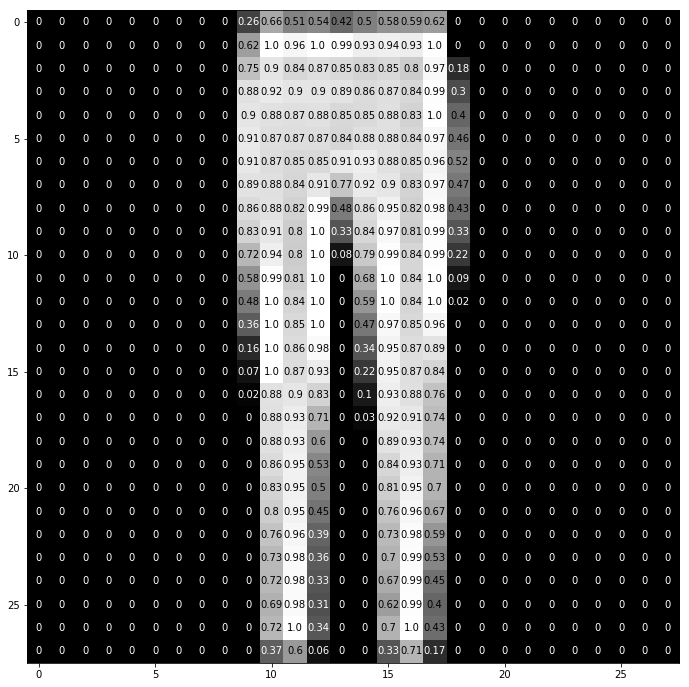

In [9]:
# select an image by index
idx = 7
img = np.squeeze(images[idx])

# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Define the network architecture

In [127]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel (grayscale, 10 ouput channels, 3x3 convolution kernel)
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(10)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.batch_norm2 = nn.BatchNorm2d(20)
        
        self.fc1 = nn.Linear(20*5*5, 64)
        self.fc1_dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm1(self.pool(F.relu(self.conv1(x))))
        x = self.batch_norm2(self.pool(F.relu(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc1_dropout(x)
        x = self.fc2(x)
        # Apply softmax function to get a distribution of class scores
        x = F.log_softmax(x, dim=1)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=500, out_features=64, bias=True)
  (fc1_dropout): Dropout(p=0.5)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


### Specify the loss function and optimizer 

In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

### Accuracy before training 

#### Variable

Before an input tensor can be processed by a model, it must be wrapped in a Variable wrapper; this wrapper gives PyTorch the ability to automatically track how this input changes as it passes through the network and automatically calculate the gradients needed for backpropagation.

In [129]:
correct = 0
total = 0

# Iterate through the dataset 
for images, labels in test_loader:
    # warp input images in a Variable wrapper
    #images = Variable(images)
    # Forward pass to get outputs (series of class scores)
    outputs = net(images)
    # Get the predicted class from the maximum value in the ouput-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    # Count up total number of correct labels 
    total += labels.size(0)
    correct += (predicted == labels).sum()

# Calculated te accuracy
accuracy = 100*correct.item()/total

print("Accuracy before training: ", accuracy, "%")

Accuracy before training:  12.0 %


### Train the network

In [130]:
def train(n_epochs):
    loss_over_time = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # Get the input iamges and their corresponding labels
            inputs, labels = data
            # Wrap them in a torch variable
            inputs, labels = Variable(inputs), Variable(labels)
            # Zero the parameter (weight) gradients
            optimizer.zero_grad()
            # Forward pass to get outputs 
            outputs = net(inputs)
            # Calculate loss
            loss = criterion(outputs, labels)
            # Backward pass to calculate the parameter gradients 
            loss.backward()
            # Update parameters 
            optimizer.step()
            # To convert loss into a scalar and add it to running los, we use ,item()
            running_loss += loss.item()
            # print loss statistics
            if batch_i % 1000 == 999: # print every 1000 mini-batches
                avg_loss = running_loss/1000
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch+1, batch_i+1, running_loss/1000))
                running_loss = 0.0
    print("Training finished")
    return loss_over_time
    
n_epochs = 15
training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 0.588724569350481
Epoch: 2, Batch: 1000, Avg. Loss: 0.3815254794806242
Epoch: 3, Batch: 1000, Avg. Loss: 0.34785287392139436
Epoch: 4, Batch: 1000, Avg. Loss: 0.3176263613365591
Epoch: 5, Batch: 1000, Avg. Loss: 0.30882720194756985
Epoch: 6, Batch: 1000, Avg. Loss: 0.29214364499598744
Epoch: 7, Batch: 1000, Avg. Loss: 0.28456708873435854
Epoch: 8, Batch: 1000, Avg. Loss: 0.2828258928954601
Epoch: 9, Batch: 1000, Avg. Loss: 0.27497926339134576
Epoch: 10, Batch: 1000, Avg. Loss: 0.26479853137210013
Epoch: 11, Batch: 1000, Avg. Loss: 0.2632584364488721
Epoch: 12, Batch: 1000, Avg. Loss: 0.2495268140770495
Epoch: 13, Batch: 1000, Avg. Loss: 0.25018868216499685
Epoch: 14, Batch: 1000, Avg. Loss: 0.24212542602047324
Epoch: 15, Batch: 1000, Avg. Loss: 0.24413345504552125
Training finished


### Visualizing loss 

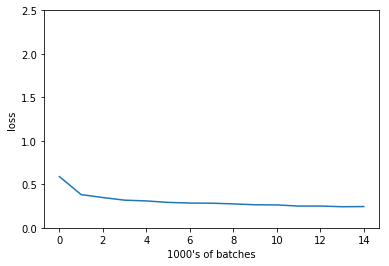

In [131]:
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

### Test the training network

In [132]:
# Initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Set the module to evaluation mode 
net.eval()

for batch_i, data in enumerate(test_loader):
    inputs, labels  = data
    # Volatile means we do not have to track how the inputs change
    # inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    # Update average test loss 
    test_loss = test_loss + ((torch.ones(1)/ (batch_i+1))*(loss.data -test_loss))
    _, predicted = torch.max(outputs.data, 1)
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # Calculate the accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        
print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.276968

Test Accuracy of T-shirt/top: 86% (861/1000)
Test Accuracy of Trouser: 97% (976/1000)
Test Accuracy of Pullover: 85% (850/1000)
Test Accuracy of Dress: 91% (914/1000)
Test Accuracy of  Coat: 86% (868/1000)
Test Accuracy of Sandal: 97% (977/1000)
Test Accuracy of Shirt: 67% (670/1000)
Test Accuracy of Sneaker: 95% (958/1000)
Test Accuracy of   Bag: 98% (980/1000)
Test Accuracy of Ankle boot: 97% (970/1000)

Test Accuracy (Overall): 90% (9024/10000)


### Visualize sample test results 

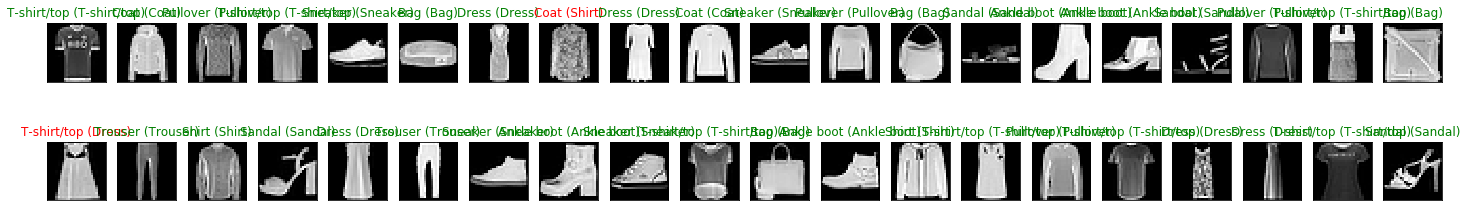

In [133]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Save model

In [134]:
model_dir = 'models/'
model_name = 'model1.pt'

torch.save(net.state_dict(), model_dir+model_name)

## Load a trained, saved model

In [50]:
# instantiate the Net (class defined above)
net = Net()
# Load the net parameters 
net.load_state_dict(torch.load(model_dir+model_name))
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)
